In [1]:
import pandas as pd
from folium import plugins, Map, CircleMarker
from folium.plugins import HeatMap
import geopandas as gpd
import folium
import geopy
import asyncio
from shapely.geometry import Polygon, Point
from pandas.io.json import json_normalize

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
#Use the shape file to get additional data
sidewalks =gpd.read_file('/Users/akarvin/Documents/studies/cs506/final project/data/shape/Sidewalks.shx')
sidewalks_hazards = gpd.read_file('/Users/akarvin/Documents/studies/cs506/final project/data/shape/Sidewalk_Hazards.shx')

In [3]:
geolocator = geopy.Nominatim(user_agent='my-application1')
async def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))

    return location.raw['address']

async def get_response(zipcodes):
    return await asyncio.gather(**zipcodes)
def process_sidewalks_hazards():
    #Convert the points to lat to long of sidewalks_hazards
    data = folium.GeoJson(data=sidewalks_hazards["geometry"])
    #Convert lat long to dataframe
    coord = { "x" : [], "y" : [] }
    for i in range(len(data.data['features'])):
        
        coord["x"].append(float(data.data['features'][i]['geometry']['coordinates'][0]))
        coord["y"].append(float(data.data['features'][i]['geometry']['coordinates'][1]))    
    
    zipcodes = []
    for index,row in coord.iterrows():
        zipcodes.append(asyncio.ensure_future(get_zipcode(row, geolocator,lat_field='y', lon_field='x')))
    
    #Wait till all the threads are finished running and get the data
    #Takes a long time to runn
    response = asyncio.run(get_response(zipcodes))
    sidewalks_hazards['address'] = response
    sidewalks_hazards['pincode'] = sidewalks_hazards['address'].apply(lambda x: x['postcode'])
    #Save the file
    sidewalks_hazards.to_csv("sidewalks_hazards_withaddress.csv")


In [4]:
sidewalks.dtypes

SWK_ID          object
MATERIAL        object
SWK_WIDTH       object
DISTRICT        object
SWK_AREA        object
PARENT          object
SEG_ID          object
SIDE            object
CG_ID           object
Rpr_Yr           int64
New_SCI          int64
Recon_Date      object
HPNETWORK        int64
TEST_AREA      float64
COST_RECON     float64
GOODCANDID       int64
TOTAREA        float64
geometry      geometry
dtype: object

In [5]:
# Clean the SWK_WIDTH AND SWK_AREA Column
def clean(sidwalks):

    sidewalks['SWK_WIDTH'] = (sidewalks['SWK_WIDTH'].str.replace(" ",""))
    sidewalks['SWK_WIDTH'] = (sidewalks['SWK_WIDTH']).str.replace("O","0")
    sidewalks['SWK_WIDTH'] = sidewalks['SWK_WIDTH'].str.replace("l","")
    sidewalks['SWK_WIDTH'] = sidewalks['SWK_WIDTH'].str.replace(",",".")
    sidewalks['SWK_WIDTH'] = sidewalks['SWK_WIDTH'].astype(float)
    sidewalks['SWK_AREA'] = sidewalks['SWK_AREA'].astype(float)
    return sidewalks


In [6]:
sidewalks = clean(sidewalks)
sidewalks.groupby('DISTRICT').agg({'SWK_WIDTH' : 'mean', 'SWK_AREA' : 'mean'})

,SWK_WIDTH,SWK_AREA
DISTRICT,,
ALLSTON/BRIGHTON,6.542724,2381.861342
CHARLESTOWN,8.149412,1895.730481
DOWNTOWN,8.646959,2864.800000
EAST BOSTON,8.810446,2908.683761
HYDE PARK,6.096727,2433.337152
JAMAICA PLAIN,6.240322,2138.124641
NORTH DORCHESTER,6.325244,2096.217554
NORTH END,7.895376,1699.973580
ROXBURY,8.335938,4670.447917


In [7]:
sidewalks.groupby('MATERIAL').agg({'SWK_WIDTH' : 'mean', 'SWK_AREA' : 'mean'})

,SWK_WIDTH,SWK_AREA
MATERIAL,,
BC,6.452790,2563.448661
BL,6.562500,1720.625000
BR,10.235861,2768.239336
CB,11.441635,3337.020913
CC,6.786158,2357.304937
GB,14.615663,4886.590361
OT,4.976271,2478.186441
OTHER,6.888889,4355.518519
UNK,0.305281,1054.359736


In [ ]:
#Create the map
map = folium.Map()
data = folium.GeoJson(sidewalks['geometry'])
data.add_to(map)
map.save('Sidewalks.html')


In [ ]:
sidewalks.groupby(['DISTRICT','MATERIAL']).count()['SWK_ID']

DISTRICT                     MATERIAL
ALLSTON/BRIGHTON             BC            51
                             BR             8
                             CB            26
                             CC          1846
                             OTHER          3
                                         ... 
WEST ROXBURY AND ROSLINDALE  BC             5
                             BR             1
                             CC           115
                             OT             1
                             UNK           10
Name: SWK_ID, Length: 104, dtype: int64

In [ ]:
sidewalks.groupby('DISTRICT')['MATERIAL'].agg(pd.Series.mode)

DISTRICT
ALLSTON/BRIGHTON               CC
CHARLESTOWN                    CC
DOWNTOWN                       CC
EAST BOSTON                    CC
HYDE PARK                      CC
JAMAICA PLAIN                  CC
NORTH DORCHESTER               CC
NORTH END                      CC
ROXBURY                        CC
ROXBURY 10A                    CC
ROXBURY 10B                    CC
SOUTH BOSTON                   CC
SOUTH DORCHESTER               CC
THE NORTH END                  CC
WEST ROXBURY                   CC
WEST ROXBURY AND ROSLINDALE    CC
Name: MATERIAL, dtype: object

In [ ]:
public_schools = pd.read_csv('../data/Public_Schools.csv')

import utm

In [ ]:
from shapely.geometry import Polygon, Point
x = public_schools['X'][0]
y = public_schools['Y'][0]
distance = Point(public_schools['X'][1],public_schools['Y'][1]).distance(Point(x,y))

In [ ]:
x

790128.152747571

In [ ]:
y

2967094.3776232

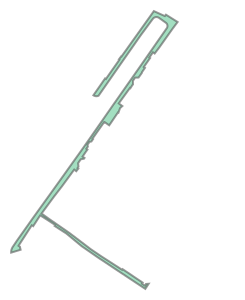

In [ ]:
sidewalks.iloc[0]['geometry']

In [ ]:
map = folium.Map()
data = folium.GeoJson(sidewalks['geometry'])
data.add_to(map)
map.save('../maps/sidewalkss_map.html')

t

In [ ]:
from pandas.io.json import json_normalize
public_schools =  gpd.read_file("../data/Public_Schools.geojson")


In [ ]:
sidewalks = sidewalks.to_crs(32612)
public_schools  = public_schools.to_crs(32612)

In [ ]:
public_schools['temp'] = 1
sidewalks['temp'] = 1
sidewalks['id'] = sidewalks.index
sidewalks = sidewalks[sidewalks['geometry'].notna()]


In [ ]:
result = pd.merge(public_schools,sidewalks, on = 'temp' )

In [ ]:
result['distance'] = result.apply(lambda x: x['geometry_x'].distance(x['geometry_y'])/1000, axis = 1)

In [ ]:
merged_school_sidewalk = result.loc[result.groupby('id')['distance'].idxmin()]

In [ ]:
id[['SWK_ID','SCH_NAME','ADDRESS','DISTRICT','distance']]

,SWK_ID,SCH_NAME,ADDRESS,DISTRICT,distance
256817,1,Edwards Middle,28 Walker Street,CHARLESTOWN,0.306655
1424168,402,Young Achievers K-8,20 Outlook Road,SOUTH DORCHESTER,0.574716
1424169,403,Young Achievers K-8,20 Outlook Road,SOUTH DORCHESTER,0.521828
1424170,404,Young Achievers K-8,20 Outlook Road,SOUTH DORCHESTER,0.492425
1424171,405,Young Achievers K-8,20 Outlook Road,SOUTH DORCHESTER,0.399325
...,...,...,...,...,...
1494203,24087,Chittick Elementary,154 Ruskindale Road,HYDE PARK,0.501914
2171267,4547,Kilmer Upper (4-8),140 Russett Road,WEST ROXBURY,0.656838
2217962,21675,Kilmer Lower (K1-3),35 Baker Street,WEST ROXBURY,0.737161
2988414,5596,Eliot K-8,585 Commercial Street,NORTH END,0.213570


In [ ]:
public_schools.columns

Index(['BLDG_ID', 'BLDG_NAME', 'ADDRESS', 'CITY', 'ZIPCODE', 'CSP_SCH_ID',
       'SCH_ID', 'SCH_NAME', 'SCH_LABEL', 'SCH_TYPE', 'SHARED', 'COMPLEX',
       'OBJECTID', 'geometry', 'temp'],
      dtype='object')

In [ ]:
sidewalks['centroid'] = sidewalks['geometry'].apply(lambda x: x.centroid)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
